based on https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb

In [1]:
import os
import numpy as np
from PIL import Image
from IPython.display import display
import collections.abc as container_abcs

import torch

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = torch.cuda.is_available()
device = torch.device('cpu' if not has_cuda else 'cuda')

In [4]:
print(device)

cuda


In [5]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)

model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [6]:
def show_images(batch: torch.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    n = np.ceil(np.sqrt(batch.shape[0])).astype(int)
    grid = np.zeros((n * batch.shape[2], n * batch.shape[3], batch.shape[1])).astype(np.uint8)
    reshaped = scaled.permute(0, 2, 3, 1).numpy()
    for i, img in enumerate(reshaped):
        ix, iy = i // n, i % n
        grid[ix * batch.shape[2]:(ix + 1) * batch.shape[2], 
             iy * batch.shape[3]:(iy + 1) * batch.shape[3]] = img
    display(Image.fromarray(grid))

### Sample from the base model

In [7]:
# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = torch.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = torch.cat([half_eps, half_eps], dim=0)
    return torch.cat([eps, rest], dim=1)

In [8]:
# Sampling parameters
prompt = "a picture of a volcano erruption"
batch_size = 16
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

In [9]:
# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
print(tokens)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)
print(tokens)

[64, 4286, 286, 257, 32410, 1931, 6417]
[64, 4286, 286, 257, 32410, 1931, 6417, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]


In [10]:
tokens

[64,
 4286,
 286,
 257,
 32410,
 1931,
 6417,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 5

In [11]:
# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

In [12]:
# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=torch.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=torch.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=torch.bool,
        device=device,
    ),
)

In [13]:
# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

  0%|          | 0/100 [00:00<?, ?it/s]

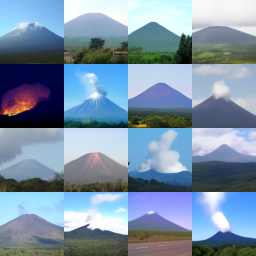

In [14]:
# Show the output
show_images(samples)